# Tutorial 1: resolution of a Poisson problem

### The problem definition

This tutorial presents how to solve with Physics-Informed Neural Networks a 2-D Poisson problem with Dirichlet boundary conditions.

The problem is written as:
\begin{equation}
\begin{cases}
\Delta u = \sin{(\pi x)} \sin{(\pi y)} \text{ in } D, \\
u = 0 \text{ on } \Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4,
\end{cases}
\end{equation}
where $D$ is a square domain $[0,1]^2$, and $\Gamma_i$, with $i=1,...,4$, are the boundaries of the square.

First of all, some useful imports.

In [1]:
import os
import numpy as np
import argparse
import sys
import torch
from torch.nn import ReLU, Tanh, Softplus
from pina.problem import SpatialProblem
from pina.operators import nabla
from pina.model import FeedForward
from pina.adaptive_functions import AdaptiveSin, AdaptiveCos, AdaptiveTanh
from pina import Condition, Span, PINN, LabelTensor, Plotter

Now, the Poisson problem is written in PINA code as a class. The equations are written as *conditions* that should be satisfied in the corresponding domains. *truth_solution*
is the exact solution which will be compared with the predicted one.

In [2]:
class Poisson(SpatialProblem):
    spatial_variables = ['x', 'y']
    bounds_x = [0, 1]
    bounds_y = [0, 1]
    output_variables = ['u']
    domain = Span({'x': bounds_x, 'y': bounds_y})

    def laplace_equation(input_, output_):
        force_term = (torch.sin(input_['x']*torch.pi) *
                      torch.sin(input_['y']*torch.pi))
        return nabla(output_['u'], input_).flatten() - force_term

    def nil_dirichlet(input_, output_):
        value = 0.0
        return output_['u'] - value

    conditions = {
        'gamma1': Condition(Span({'x': bounds_x, 'y':  bounds_y[-1]}), nil_dirichlet),
        'gamma2': Condition(Span({'x': bounds_x, 'y': bounds_y[0]}), nil_dirichlet),
        'gamma3': Condition(Span({'x':  bounds_x[-1], 'y': bounds_y}), nil_dirichlet),
        'gamma4': Condition(Span({'x': bounds_x[0], 'y': bounds_y}), nil_dirichlet),
    'D': Condition(Span({'x': bounds_x, 'y': bounds_y}), laplace_equation),
    }
    def poisson_sol(self, x, y):
        return -(np.sin(x*np.pi)*np.sin(y*np.pi))/(2*np.pi**2)

    truth_solution = poisson_sol

### The problem solution 

Then, a feed-forward neural network is defined, through the class *FeedForward*. A 2-D grid is instantiated inside the square domain and on the boundaries. This neural network takes as input the coordinates of the points which compose the grid and gives as output the solution of the Poisson problem. The residual of the equations are evaluated at each point of the grid and the loss minimized by the neural network is the sum of the residuals.
In this tutorial, the neural network is composed by two hidden layers of 10 neurons each, and it is trained for 5000 epochs with a learning rate of 0.003. These parameters can be modified as desired.
The output of the cell below is the final loss of the training phase of the PINN.

In [3]:
poisson_problem = Poisson()

model = FeedForward(layers=[10, 10],
                    output_variables=poisson_problem.output_variables,
                    input_variables=poisson_problem.input_variables)

pinn = PINN(poisson_problem, model, lr=0.003, regularizer=1e-8)
pinn.span_pts(20, 'grid', ['D'])
pinn.span_pts(20, 'grid', ['gamma1', 'gamma2', 'gamma3', 'gamma4'])
pinn.train(5000, 100)

2.384537034558816e-05

The loss trend is saved in a dedicated txt file located in *tutorial1_files*.

In [5]:
os.mkdir('tutorial1_files')
with open('tutorial1_files/poisson_history.txt', 'w') as file_:
    for i, losses in enumerate(pinn.history):
        file_.write('{} {}\n'.format(i, sum(losses)))
pinn.save_state('tutorial1_files/pina.poisson')

Now the *Plotter* class is used to plot the results.
The solution predicted by the neural network is plotted on the left, the exact one is represented at the center and on the right the error between the exact and the predicted solutions is showed. 

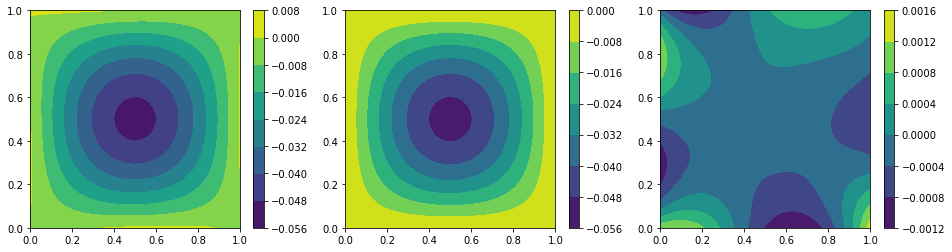

In [6]:
plotter = Plotter()
plotter.plot(pinn)

### The problem solution with extra-features

Now, the same problem is solved in a different way.
A new neural network is now defined, with an additional input variable, named extra-feature, which coincides with the forcing term in the Laplace equation. 
The set of input variables to the neural network is:

\begin{equation}
[\mathbf{x}, \mathbf{y}, \mathbf{k}(\mathbf{x}, \mathbf{y})], \text{ with } \mathbf{k}(\mathbf{x}, \mathbf{y})=\sin{(\pi \mathbf{x})}\sin{(\pi \mathbf{y})},
\end{equation}

where $\mathbf{x}$ and $\mathbf{y}$ are the coordinates of the points of the grid and $\mathbf{k}(\mathbf{x}, \mathbf{y})$ is the forcing term evaluated at the grid points. 

This forcing term is initialized in the class *myFeature*, the output of the cell below is also in this case the final loss of PINN.

In [7]:
poisson_problem = Poisson()

class myFeature(torch.nn.Module):
    """
    """
    def __init__(self):
        super(myFeature, self).__init__()

    def forward(self, x):
        return (torch.sin(x['x']*torch.pi) *
                torch.sin(x['y']*torch.pi))
    
feat = [myFeature()]
model_feat = FeedForward(layers=[10, 10],
                    output_variables=poisson_problem.output_variables,
                    input_variables=poisson_problem.input_variables,
                    extra_features=feat)

pinn_feat = PINN(poisson_problem, model_feat, lr=0.003, regularizer=1e-8)
pinn_feat.span_pts(20, 'grid', ['D'])
pinn_feat.span_pts(20, 'grid', ['gamma1', 'gamma2', 'gamma3', 'gamma4'])
pinn_feat.train(5000, 100)

7.93498870023341e-07

The losses are saved in a txt file as for the basic Poisson case.

In [8]:
with open('tutorial1_files/poisson_history_feat.txt', 'w') as file_:
        for i, losses in enumerate(pinn_feat.history):
            file_.write('{} {}\n'.format(i, sum(losses)))
pinn_feat.save_state('tutorial1_files/pina.poisson_feat')

The predicted and exact solutions and the error between them are represented below.

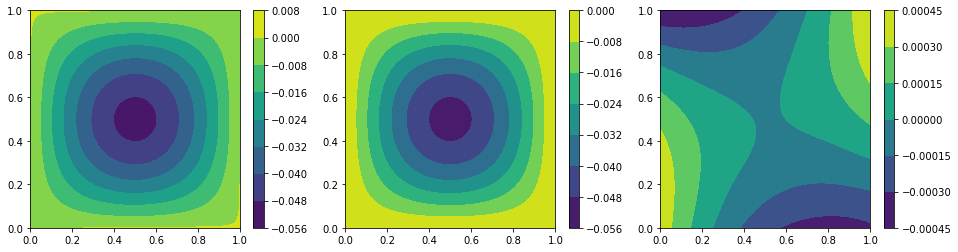

In [9]:
plotter_feat = Plotter()
plotter_feat.plot(pinn_feat)

### The problem solution with learnable extra-features

Another way to predict the solution is to add a parametric forcing term of the Laplace equation as an extra-feature. The parameters added in the expression of the extra-feature are learned during the training phase of the neural network. For example, considering two parameters, the parameteric extra-feature is written as:

\begin{equation}
\mathbf{k}(\mathbf{x}, \mathbf{y}) = \beta \sin{(\alpha \mathbf{x})} \sin{(\alpha \mathbf{y})}
\end{equation}

The new Poisson problem is defined in the dedicated class *ParametricPoisson*, where the domain is no more only spatial, but includes the parameters' space. In our case, the parameters' bounds are 0 and 30. 

In [10]:
from pina.problem import ParametricProblem

class ParametricPoisson(SpatialProblem, ParametricProblem):
    bounds_x = [0, 1]
    bounds_y = [0, 1]
    bounds_alpha = [0, 30]
    bounds_beta = [0, 30]
    spatial_variables = ['x', 'y']
    parameters = ['alpha', 'beta']
    output_variables = ['u']
    domain = Span({'x': bounds_x, 'y': bounds_y})

    def laplace_equation(input_, output_):
        force_term = (torch.sin(input_['x']*torch.pi) *
                      torch.sin(input_['y']*torch.pi))
        return nabla(output_['u'], input_).flatten() - force_term

    def nil_dirichlet(input_, output_):
        value = 0.0
        return output_['u'] - value

    conditions = {
        'gamma1': Condition(
            Span({'x': bounds_x, 'y': bounds_y[1], 'alpha': bounds_alpha, 'beta': bounds_beta}),
            nil_dirichlet),
        'gamma2': Condition(
            Span({'x': bounds_x, 'y': bounds_y[0], 'alpha': bounds_alpha, 'beta': bounds_beta}),
            nil_dirichlet),
        'gamma3': Condition(
            Span({'x': bounds_x[1], 'y': bounds_y, 'alpha': bounds_alpha, 'beta': bounds_beta}),
            nil_dirichlet),
        'gamma4': Condition(
            Span({'x': bounds_x[0], 'y': bounds_y, 'alpha': bounds_alpha, 'beta': bounds_beta}),
            nil_dirichlet),
        'D': Condition(
            Span({'x': bounds_x, 'y': bounds_y, 'alpha': bounds_alpha, 'beta': bounds_beta}),
            laplace_equation),
    }
    
    def poisson_sol(self, x, y):
        return -(np.sin(x*np.pi)*np.sin(y*np.pi))/(2*np.pi**2)


Here, as done for the other cases, the new parametric feature is defined and the neural network is re-initialized and trained, considering as two additional parameters $\alpha$ and $\beta$. 

In [11]:
param_poisson_problem = ParametricPoisson()

class myFeature(torch.nn.Module):
    """
    """
    def __init__(self):
        super(myFeature, self).__init__()

    def forward(self, x):
        return (x['beta']*torch.sin(x['alpha']*x['x']*torch.pi)*
               torch.sin(x['alpha']*x['y']*torch.pi))

feat = [myFeature()]
model_learn = FeedForward(layers=[10, 10],
                    output_variables=param_poisson_problem.output_variables,
                    input_variables=param_poisson_problem.input_variables,
                    extra_features=feat)

pinn_learn = PINN(poisson_problem, model_feat, lr=0.003, regularizer=1e-8)
pinn_learn.span_pts(20, 'grid', ['D'])
pinn_learn.span_pts(20, 'grid', ['gamma1', 'gamma2', 'gamma3', 'gamma4'])
pinn_learn.train(5000, 100)

3.265163986679126e-06

The losses are saved as for the other two cases trained above.

In [12]:
with open('tutorial1_files/poisson_history_learn_feat.txt', 'w') as file_:
    for i, losses in enumerate(pinn_learn.history):
        file_.write('{} {}\n'.format(i, sum(losses)))
pinn_learn.save_state('tutorial1_files/pina.poisson_learn_feat')

Here the plots for the prediction error (below on the right) shows that the prediction coming from the **parametric PINN** is more accurate than the one of the basic version of PINN.

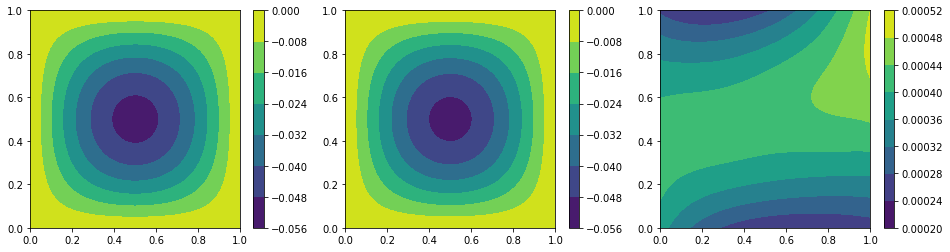

In [13]:
plotter_learn = Plotter()
plotter_learn.plot(pinn_learn)

Now the files containing the loss trends for the three cases are read. The loss histories are compared; we can see that the loss decreases faster in the cases of PINN with extra-feature.

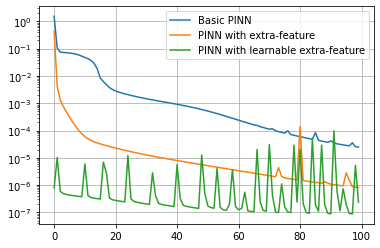

In [14]:
import pandas as pd
  
df = pd.read_csv("tutorial1_files/poisson_history.txt", sep=" ", header=None)
epochs = df[0]
poisson_data = epochs.to_numpy()*100
basic = df[1].to_numpy()

df_feat = pd.read_csv("tutorial1_files/poisson_history_feat.txt", sep=" ", header=None)
feat = df_feat[1].to_numpy()

df_learn = pd.read_csv("tutorial1_files/poisson_history_learn_feat.txt", sep=" ", header=None)
learn_feat = df_learn[1].to_numpy()

import matplotlib.pyplot as plt
plt.semilogy(epochs, basic, label='Basic PINN')
plt.semilogy(epochs, feat, label='PINN with extra-feature')
plt.semilogy(epochs, learn_feat, label='PINN with learnable extra-feature')
plt.legend()
plt.grid()
plt.show()